In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [3]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [4]:
function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

h_times = LinRange(0,30,200+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 10/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    envelope(t)*out/w_sum
end

# function envelope(t)
#     if t < 0.1
#         return sin(pi/2*t/0.1)^2
#     elseif 30-0.1 < t <= 30
#         return cos(pi/2*(t-0.1)/0.1)^2
#     else
#         return 1
#     end
# end

# h_times = LinRange(0,30,200+2)[2:end-1]
# dt = h_times[2] - h_times[1]
# function pulse(p,t)
#     out = 0
#     w_start = exp( - 5/(2*dt^2) * (t - 0)^2)
#     w_end = exp( - 5/(2*dt^2) * (t - 30)^2)
#     w_sum = w_start + w_end
#     for (i, ht) in enumerate(h_times)
#         w = exp( - 5/(2*dt^2) * (t - ht)^2)
#         out += p[i] * w
#         w_sum += w
#     end
#     envelope(t)*out/w_sum
# end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

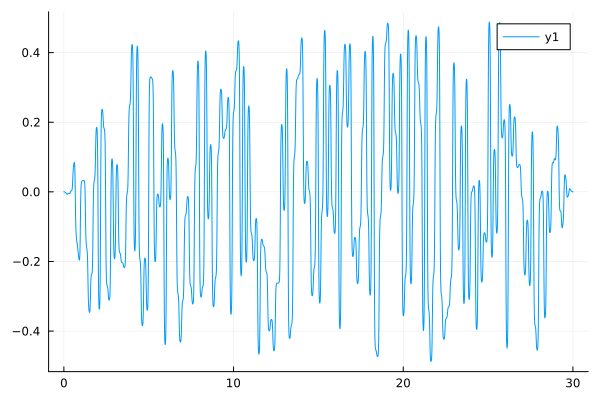

In [6]:
times = LinRange(0,30,5000)
p = readdlm("..\\..\\JuliaStuff\\params.txt")[1,:] ;
# rand_ps = rand(200).-0.5
# rand_ps = readdlm("tmp_paramsmm.txt")[1,:]
plot(times,[pulse(p,t) for t in times])

In [7]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

ψ0 = cat(zeros(ComplexF64,NHilbert,1),zeros(ComplexF64,NHilbert,1),dims=2)
ψ0[1,1] = 1
ψ0[2,2] = 1

fu0 = ψ0
fu0 = cat(fu0,zeros(1,2),dims=1)

# p = 0.01 .*(rand(200).-0.5) ;#zeros(72) ; 
# p = sum([sin.(ω .*h_times) for ω in [Es[5]-Es[1], Es[6]-Es[1], Es[5] - Es[2], Es[6] - Es[2]]],dims=1)[1]

sizep = length(p)

# D = spdiagm(Es.- Es[1]) ;
# D = Es.- Es[1]
V = ψs'*chargecoupling*ψs ;

In [8]:
lfactor = 0.5/30

ψproj = ψs'*ψs[:,[1,2,5,6]]*ψs[:,[1,2,5,6]]'*ψs
ψproj[abs2.(ψproj) .< 1e-5 ] .= 0
ψproj *= lfactor

Xproj = ψs'*ψs[:,[1,2,5,6]]
Xproj[abs2.(Xproj) .< 0.5] .= 0

# ψproj = ψs[:,[1,2,5,6]]*(ψs[:,[1,2,5,6]]')
;

In [9]:
function f!(du, u, p, t)
    x = u[1:end-1,1:2]
    α = 1
    expd = exp.(im*t .*Es)
    H = pulse(p,t) .* (expd.*V.*(expd'))
    # H = KinPot12 + Potential3 + pulse(p,t) .* chargecoupling

    du[1:end-1,1:2] = -im .* (H * x)

    proj = abs2.(Xproj'*x)

    du[end,1] = sum(proj)
end

l1sscale = 0

# * l1sscale
function b!(du, u, p, t)
    x = u[:,1:2]
    λ = u[:,3:4]
    α = 1
    dpdp = dpulsedp(p,t)

    expd = exp.(im*t .*Es)
    Uv = expd.*V.*(expd')
    miH = -im * pulse(p,t) .* Uv
    # miH = -im .* (KinPot12 + Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * λ - ψproj*x
    
    du[1:sizep,5] = 2 .* (
    - real(im * tr(λ' * Uv * x)) .* dpdp )
end

b! (generic function with 1 method)

In [10]:
ls = []
l1s = []
params = []
counter = [0]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        counter[1] += 1
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        xT = sol_f.u[end][1:end-1,1:2]

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        int_inf = 1 - lfactor * real(sol_f.u[end][end,1])

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        loss[1] = infidelity + int_inf
        grad[:] = real(sol_b.u[end][1:sizep,5])
        push!(ls, copy(infidelity))
        push!(l1s, copy(int_inf))
        push!(params, copy(p))

        if counter[1]%5 == 0
            image = plot([ls,ls + l1s],yscale=:log10,ylim=(1e-5,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmp_ls_r0.txt",ls)
            writedlm("tmp_l1s_r0.txt",l1s)
            writedlm("tmp_paramsmm_r0.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    println(ls[end]," ",l1s[end])#," ",l2s[end]," ",loss[1])
end

get_grad! (generic function with 1 method)

In [11]:
initial_p = copy(p)
last_p = similar(initial_p);

In [12]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

0.9978334367027892 0.0664205269386633


0.9975661621790831 0.04607059135398728


0.9968335848701277 0.02289589035781281


0.9966004616056197 0.017690272601816104


0.9954231561140198 0.009893419851185858


0.9951668269594544 0.009618164792302597


0.9940512290060616 0.00895168556429804


0.9779859608863671 0.01169142187356309


0.812073501171452 0.14102534152116808


0.7043915295871581 0.16793557273575865


0.566474736153074 0.3507909630983175


0.5429418641595616 0.23982631223705086


0.90655265958626 0.6251114145336096


0.47608974285323785 0.28659863652303685


0.4462794917550902 0.12832425032547645


0.29474735549319014 0.14343295826444125


0.22807437937832975 0.13212351951115076


0.15429318378545148 0.09132759208476193


0.12218422649667027 0.05960735617978141


0.1055304983019128 0.0595332856155224


0.08468126576436663 0.05485471411423304


0.08045366223961381 0.04919207681950544


0.07675884371354169 0.044159530208719766


0.0708046152415413 0.03977269938602068


0.0636050875417179 0.03744956588506121


0.0584617570841538 0.03577154298314722


0.05453532894717367 0.034268298375560335


0.05031237003931455 0.032848282789280536


0.04458622030149806 0.032397387002117806


0.039259600434364106 0.03229667280685489


0.03499432462532387 0.03200214598814044


0.03226367097167038 0.0310610258941717


0.03005855850524025 0.030356637805786457


0.028360079664499604 0.02953784938533688


0.026473655407727836 0.028923838219603204


0.024617675186477284 0.02819256354796118


0.022806252816415518 0.027685691941725432


0.02138372318483661 0.0272297632979549


0.020224575910701592 0.026708305456927706


0.01894914638123657 0.02627199693108806


0.01762185547241546 0.02598147769812187


0.01632745451366685 0.02601586257192101


0.015493779323785817 0.025940768398435177


0.01478212738396495 0.025880518576221867


0.01427507272646722 0.025564598377185277


0.013638564416631027 0.02528658419427099


0.013091212037155908 0.02489481739978172


0.012444741226918576 0.02468201786062485


0.011858984949826845 0.02453678265207293


0.011242209751779031 0.024527237903500754


0.010712352354215693 0.024490432048137167


0.010273131632034138 0.024421970931948866


0.00995676383037325 0.024280594571939207


0.009661379869699449 0.024146361584949205


0.009347768644385801 0.024032454644878798


0.008993672226564331 0.023977708819014842


0.008678811811057008 0.023950979909824754


0.008415142510566076 0.02393258905889384


0.008164806692973592 0.02388820658019042


0.0078913522074599 0.02380133970959941


0.007626010713634335 0.02366771672451584


0.007407775598937905 0.023514867744490187


0.007211692473513165 0.02337203507056551


0.0069913071755765 0.02322918033704624


0.006733031450614435 0.0231026594575634


0.0065060608456642965 0.023008120176493008


0.00631753923740852 0.022968981706099623


0.006155844340727301 0.022929344334295276


0.005956833204895817 0.02288919118559718


0.0057953325294560765 0.022801915094464498


0.005665210817516642 0.022735252663333982


0.005617927168318215 0.022627676770230254


0.005524131173538227 0.022554353327984167


0.005491922320666642 0.02239599718149099


0.005383968922519133 0.022332345315961066


0.005369097673098733 0.022219640577626043


0.005273545287917847 0.022198876726434502


0.00519336649533253 0.022124755456558787


0.0050579566985914926 0.02206051015505872


0.004954483932863685 0.02195529735353685


0.004861109004081932 0.021849328767717724


0.004797479816656902 0.02171034482106926


0.0047255140588498 0.021580079003919117


0.004667248284229042 0.02147788541076523


0.00460501861373247 0.02142454270609584


0.0045504581141565525 0.021361568129821595


0.004479568430805325 0.021266546636609096


0.004425704163495803 0.02112006778354425


0.004390701495395777 0.020996460465164013


0.004378904490086877 0.020916792297087095


0.0043514961561669785 0.02087059982685524


0.004311553577524385 0.020801993601430202


0.004228245492112204 0.020732594866479936


0.004128231938119231 0.020676120570668366


0.004015736690502314 0.02066833661184475


0.003930886365236641 0.020651497389732487


0.0038330525857976916 0.02063629582897819


0.0037710693601152867 0.020582749155337865


0.0037311211167938563 0.020533593674199047


0.003742565564245126 0.02045345948720534


0.0037483097793127307 0.02036815878075371


0.0037820034883349063 0.02022359313703126


0.0037837914004247297 0.02010250470552377


0.0037752808672070204 0.02002452723984871


0.0037239264496290447 0.02001569750965082


0.00366790739006434 0.02000527703534305


0.0035861252953785505 0.020004930929354625


0.0035378184039562832 0.019979599494104994


0.0035160925178930325 0.019952202387482187


0.0035191182484103356 0.019906852554047783


0.0035225556198179575 0.01984148276858988


0.003523932378395489 0.019751497988109157


0.003507994384935431 0.019680068831593567


0.00347736080098926 0.019652796945352602


0.0034394523499349794 0.019647603061931807


0.003390590261568349 0.019641491730673866


0.003337895661680801 0.01961996768215979


0.0033103737069921646 0.019574640421643696


0.0033152591129703146 0.01951714485319822


0.0033327102356595084 0.019456205707978458


0.0033479816582633326 0.01938312773443207


0.003350705926782216 0.019300259780693718


0.003320023361056079 0.01925028941377116


0.003271268652027759 0.01924063211025029


0.003200902211224821 0.019263048350144474


0.003113021361248469 0.01928990018408383


0.0029941781122401756 0.01933306640189647


0.0029224869231745387 0.01933890002143368


0.002886549858430898 0.019333744293325572


0.002897306412945111 0.0192929011848767


0.0028940551958072658 0.019260943487026783


0.002899690837826596 0.019210765691156317


0.0028801469415291603 0.019187390694153428


0.0028608358125870037 0.019169256980188787


0.002826920097465657 0.019162708295626274


0.002795241011939009 0.019144058015889365


0.0027756530804202706 0.019113652403179637


0.0027815363606636945 0.019070566233151287


0.002791858589762719 0.01903044960429645


0.002799619183719182 0.018985101878790767


0.002793415602839411 0.018937577474195444


0.002767644288072968 0.01890462574839258


0.0027250195881018957 0.018900546862228973


0.002678442877495524 0.018911740606094907


0.0026254494939651485 0.018927618950229208


0.002575238266636082 0.018932657325230196


0.002546096342851023 0.018919899857144373


0.002553423264733845 0.018882324642437998


0.002563542296474486 0.018845856009487072


0.0025935993723744666 0.018779239347638366


0.0026066544416109005 0.018714352664390255


0.002635544537733625 0.018632793905831835


0.0026088399744459423 0.018623112119029672


0.0025996252451868096 0.018608065032933108


0.0025622192963479784 0.018618711434637447


0.002528289876055967 0.0186100401674002


0.00249459263339169 0.01859303918118327


0.002484189840680162 0.01855815373867209


0.0024748584659194384 0.018528151316717145


0.0024589892074610153 0.018501055605428585


0.0024273657050655206 0.018487768344258138


0.002393842658687473 0.018487496128679948


0.0023703164302337765 0.018491591957494502


0.0023551918156861085 0.018490068490609524


0.002342694525288014 0.01847566207856033


0.002338692547264598 0.018435345639397416


0.002349436384518344 0.018373125368918775


0.0023707864282317415 0.018316052816699346


0.002377204997675464 0.018290844133419304


0.0023816630001423644 0.018271358187614495


0.002370606820247423 0.01826080754092374


0.0023710961006296882 0.018228962121505377


0.0023520944830927037 0.018215120603859325


0.0023629583092147355 0.01818192603592872


0.002352372612943854 0.01817901563769897


0.0023586415233058378 0.0181590149495362


0.0023565713582111014 0.01814107566380163


0.0023617265156814504 0.018114125570946493


0.0023576882181215453 0.018100382481978206


0.0023518513513700046 0.018091488141795953


0.0023368579865675754 0.018088709401196112


0.0023179587912449673 0.018083805704949163


0.002298421025616948 0.018079869566571594


0.002293343864736508 0.01807048358433605


0.002290722382065291 0.018065279461842


0.0022891187613627295 0.018059048200280148


0.0022790816654209567 0.018056561081865374


0.0022616186421302586 0.018056524265620433


0.0022335721018844623 0.018066699462697677


0.002209101709196193 0.01807748574153767


0.002187772767492324 0.018087460513998344


0.0021719177896346586 0.018090789455986744


0.0021609027200445996 0.018088835749137888


0.002159594315930935 

0.01808026891963499
0.002158669017368775 0.01807440221997103


0.002156938516776452 0.01806894379707491


0.0021491353974419924 0.018065020854514557


0.002135364840963161 0.01806156059775077


0.002118554954529117 0.018061023465262838


0.002109535416926378 0.01805858417906092


0.002106986334002914 0.01805277902612412


0.002110923920558061 0.018037214158511894


0.002123899552139874 0.018002557217103976


0.002149463951449937 0.01794617460854986


0.0021722343363785868 0.01789715317712659


0.002178596083129425 0.017877974044642975


0.002171800300488913 0.01787815421802641


0.0021617224721737216 0.017879296528229727


0.002143510046007102 0.017879836178047337


0.0021289507916144035 0.017868208265095165


0.0021228965814981127 0.017850445843564766


0.0021345018810125516 0.017827225032401084


0.0021394976181249303 0.017817011569120078


0.002150688347192009 0.01780016530187678


0.0021601058121288874 0.01777996345014976


0.002171679766878487 0.01775224251320673


0.002169265796833353 0.017741454068575968


0.0021590684394324766 0.017745687635940977


0.0021489133977499186 0.017752561990471483


0.00213750262133261 0.017759131769834458


0.0021235201166196482 0.017763793839754904


0.0021123110298376657 0.01776070457962431


0.0021125205730597174 0.01774643318643776


0.0021216664133159036 0.017729581155261687


0.002128484183270274 0.017719228712999913


0.0021311760930202706 0.0177128301645606


0.002128953444046233 0.017707763112170594


0.0021148399362685977 0.017709423532231705


0.00208641520384506 0.017722567281783452


0.0020581528932477333 0.017740137138848033


0.0020463836725377327 0.01774685157085565


0.002044339580970611 0.017745242302804054


0.00204849214049474 0.017734564532384534


0.002061978915288698 0.01770845556530254


0.0020881609090174225 0.01766304122066864


0.00211327273813261 0.017620675757703874


0.00212111255711378 0.01760474056039485


0.002116059537585313 0.017606780246004594


0.0021089125556970068 0.01761130416997514


0.0020959976269466774 0.01761822690848025


0.0020786697340750004 0.017622826651095047


0.00206566893877147 0.017616532666363427


0.0020695329367068638 0.01759532970014932


0.0020829397151963525 0.017573582816428956


0.0020929775497419145 0.01756004217539786


0.002099082894068127 0.01755032643435206


0.0021074582142289744 0.017533906314369463


0.0021113148612627586 0.017514430287094318


0.002108154475198465 0.017494545852462795


0.002087982868642091 0.017495713726155215


0.002070299420934618 0.01750460183291702


0.0020563736853641545 0.017514818420556466


0.002049369221180597 0.01751793934555168


0.002039134323158276 0.017518570856838167


0.002030203400759323 0.017510247371646637


0.002029716631518741 0.017490556777238875


0.0020336270399135548 0.017473511321869584


0.0020402209239400726 0.017461686092505646


0.0020406562620095547 0.017458577433656086


0.002042260452750022 0.01745306174821215


0.0020425534102843645 0.01744465834153286


0.002046842351007716 0.017426457434944753


0.002055814648691201 0.017400352562721655


0.002067729916621519 0.017375084590380396


0.00207452294720345 0.01736175189555833


0.0020761089154410772 0.017356701082179016


0.0020760866640081588 0.01735224960491033


0.00207186715815455 0.01734754286350204


0.002060929599469463 0.017342388402943998


0.0020387065081305944 0.017344368745922267


0.0020160458881350873 0.017353181107941373


0.002003168974334113 0.017360796391119315


0.002000061821186838 0.017361585847458283


0.0019970388024657115 0.017361379366401586


0.001996708756927257 0.017354621538609005


0.0019969031382285896 0.017342369038149008


0.0020039090913606117 0.017322773314734752


0.0020053533698688453 0.017314136990049023


0.0020076631058014716 0.01730877177879009


0.0020024333888718493 0.017311420175052605


0.0019960104588002126 0.017312588274795426


0.001978898683131447 0.017318290878449716


0.001955140115069587 0.017323757568518006


0.0019346912101082525 0.017326400794054564


0.0019300681513276796 0.01732209798432527


0.001933501184171904 0.017315646852875788


0.001935795427621012 0.017311064214667216


0.00193878530240027 0.017303348371350835


0.0019400259064130676 0.0172924144726484


0.0019351649411592509 0.01728221747616676


0.0019263296937628294 0.01727746898533078


0.0019137471586002652 0.01728356487227445


0.001911035939362149 0.01728377842424711


0.0019067335471792957 0.01728629994369013


0.001904005144719001 0.017285703327843516


0.0019008184694125352 0.017281392721871125


0.001897128758349742 0.017275202476060403


0.0018923761549578533 0.01726975363607819


0.0018863693848190088 0.01727015005071153


0.001882012804517219 0.01727233072443468


0.0018777466284773947 0.017275004969504737


0.0018719533784714582 0.017277570666444086


0.0018638029893223163 0.01727904261521751


0.0018582009366081564 0.01727301765146294


0.0018610685725308773 0.017257522494724564


0.0018722874814321444 0.017239150805473558


0.001880174561557646 0.017228751183427704


0.001884321608548789 0.01722292260245184


0.0018887187012496254 0.017215013136957058


0.0018901954891281658 0.01720633906061997


0.0018847189968221878 0.017199342510847204


0.0018637614456672447 0.017206454472105337


0.001841362474096997 0.017220487347763824


0.0018245985046883573 0.017234143968175797


0.0018192123681980976 0.017237685689849513


0.001812293635659712 0.017241298956659934


0.0018027330635417282 0.017243457107960936


0.0017895140459015524 0.01724468348143715


0.0017759764015972679 0.017243638187243948


0.001767656465398837 0.01724195493829317


0.001765591378084408 0.017239681506099558


0.0017632008943369026 0.01723981011528941


0.0017602212399155936 0.017239918485129957


0.001754166434883131 0.0172400761656748


0.0017469363435269614 0.017236677499811393


0.0017429732734280945 0.01722708896978775


0.0017472176586853516 0.017213072597074275


0.0017534851451172506 0.01720293243287696


0.00175836765633125 0.01719650539142814


0.0017618761177460307 0.017191195733680553


0.0017686179949505387 0.01718028646581027


0.0017760083207375987 0.0171643588569802


0.0017815234959682735 0.017146245466889698


0.0017756663361402913 0.017140607352252646


0.0017663501493838107 0.017144173708947386


0.0017579429399776636 0.01715034982356467


0.0017538154557826813 0.017152462574419602


0.0017463791072479529 0.017155797141005347


0.001741109010635955 0.01715338547525891


0.0017322629526575484 0.017149787567454666


0.0017320507220200954 0.017136590540445362


0.001727979616316988 0.01713244130641678


0.0017335263822885194 0.01712389221480548


0.0017295031834160257 0.017126337006309722


0.0017310354499399105 0.017122506912583324


0.0017328547840841924 0.01711542903619223


0.0017430191190488387 0.01709551702050871


0.001765521396706049 

0.01705906969290405
0.0017931708228783316 0.01701972081299985


0.0018091408105167517 0.016998439112733355


0.0018114585327120847 0.016994275902393108


0.0018095598002206836 0.01699468706991991


0.0018047466429074732 0.016996298332713322


0.001795686175480371 0.016998679508436254


0.0017826714314270742 0.016999532666284067


0.0017707881499969824 0.016996422562120528


0.0017679044684075218 0.01698901644330275


0.0017685934607854503 0.016984200913127023


0.0017713027669896686 0.016979811485921648


0.0017717676601242682 0.016977598869822308


0.0017726934063015398 0.016972913552231406


0.0017696789790286327 0.0169671325916817


0.0017638883557777874 0.016958896781832156


0.0017505929049291824 0.016955218829176055


0.0017415638419693291 0.016952748977043797


0.0017335117779420095 0.016956397621857633


0.0017361977698944764 0.016952245360816742


0.0017364878794478011 0.016950394716615746


0.0017422823488441042 0.016940843694857266


0.0017486843707556488 0.01692662526592892


0.0017647450520568153 0.01689679631213925


0.0017684168557609015 0.016875245367725555


0.0017740262724776357 0.01685587240911568


0.0017570442500374206 0.01686673213705181


0.0017528316614904282 0.01686892069915813


0.0017494512041251187 0.016870576805968707


0.0017435441578585453 0.016872303934498456


0.00173760099893161 0.016870630590898883


0.0017290405383326157 0.016865316887569648


0.0017232332583066445 

0.016854255309188604
0.0017194880271067525 0.01684623010984665


0.0017204737125511849 0.016840814274131533


0.0017202380552198693 0.016839723674535678


0.0017200294698154761 0.016838688996228757


0.001721447492542938 0.01683466225403918


0.001716959703794596 0.01683292308055384


0.0017143498889352071 0.01682414678005828


0.001700346502194694 0.016824862419484665


0.0016919852102262323 0.016824003392777453


0.0016793276748908736 0.016832485942679276


0.0016777957371378882 0.016832193802997164


0.001675182843294598 0.016833039341364153


0.0016739682513760012 0.016830608767609223


0.0016784533273281332 

0.016818913380353795
0.0016837060086553057 0.016802171683134914


0.001702586554194807 0.016770503706448614


0.0017070045821948043 0.016757921074841864


0.0017171999124916404 0.0167445654892473


0.0017137051874567821 0.016746664090949936


0.00170996492140979 0.01674855866385061


0.0017076302799178267 0.016746213320633307


0.0017065938056338714 0.0167391901942473


0.0017154041070243653 0.016716239411751044


0.0017264175144969252 0.016690038342185187


0.0017380213555127089 0.016669614985355574


0.0017372155721380733 0.01666741279311401


0.001738451684861142 0.016664937455667883


0.0017353580053503515 0.016666252738998022


0.0017324622185767025 0.01666503433646449


0.0017247965699371814 0.01666426870232074


0.0017173014185657975 0.016658006926141056


0.001708649842299681 0.01665214917774227


0.0017097049885504423 0.016642858735162136


0.0017084321020309212 0.01664141896998328


0.0017113556182347112 0.016637332688622775


0.0017121143483453949 0.016635383370913526


0.0017125736170016115 0.01663216532346723


0.0017134367773375958 0.01662758280409793


0.0017132705892312083 0.01662011390515883


0.001716310901960283 0.016605969621129257


0.0017154769258369562 0.01659559061046123


0.0017236963074682143 0.01658183720773676


0.0017187177448475532 0.016585269064762986


0.0017224002288826479 0.016580637092473594


0.0017248321965559477 0.016576697708738708


0.0017285141356981892 0.01656849956339157


0.0017343160455525197 0.016555149828521576


0.0017372720246754403 0.016537546496450006


0.0017374647489509232 0.016518459014844722


0.0017212015682127046 0.016519907117728883


0.001720357418422025 0.01651448203060324


0.0017099864672979748 0.016522878679225417


0.001713068279030061 0.016518491297167093


0.0017186769852181594 0.016511352274965807


0.001722948009618419 0.016504321561245372


0.0017310879151526404 0.016490981983637187


0.0017430593730355937 0.016468766794121126


0.0017565210934835096 0.016441079933109726


0.0017640908366212127 0.016421176455055142


0.0017648758028909195 0.016413230067025775


0.001765135245099192 0.016410035982554527


0.00176419629269281 0.016409238724578112


0.0017594778956317447 0.016410663485943


0.0017570625221364766 0.016406971577569873


0.0017419614557021568 0.016410695509912032


0.0017261964394257312 0.01640838478737361


0.001697380217589195 0.01641644914088214


0.0016788484064155784 0.016419758644104054


0.0016883870741171148 0.016403422195867212


0.0016811864576607993 0.016407587962037673


0.0016813336495172804 0.016405270743447442


0.0016748177558658095 0.01640872291229023


0.0016687731187539634 0.01641092526319643


0.0016559554798373788 0.016416689639133675


0.0016392232014328378 0.01642117078588723


0.0016136920756714135 0.01642737854875953


0.0015992089385190589 0.016419075179938347


0.001588192296052282 0.01641233251114038


0.0016019709782756353 0.016390165838896298


0.0015958238110188594 0.016393169357627246


0.0016025150130389298 0.01638446532867832


0.0016017651332598803 0.016382444187801104


0.0015988393849741822 0.016379684164870456


0.0015922583170361326 0.01637681969882021


0.0015833172088486336 0.016368984560753974


0.001576517227025842 0.01635411175233359


0.0015800562925500916 0.016330717076755263


0.0015894523092033208 0.016308947750898972


0.0015972933170461112 0.016294767340974237


0.0016007448153969595 0.016287561404124795


0.0016012732283544606 0.016283608265850846


0.0016034641962621166 0.016277640624757006


0.0016006054329389952 0.016274439506680505


0.0016039382152953086 0.01625860599594997


0.0015881957969681726 0.016252820106029242


0.001578096769039694 0.016229379066344918


0.001564230725989657 0.016213480257921797


0.001562470043239672 0.016203732116081504


0.001557280884698642 0.01620526343968809


0.0015536649590856544 0.01620685829233437


0.0015537132102048101 0.016204625956684815


0.0015553872796938983 0.016200594751644037


0.0015580120369807493 0.016193839474869187


0.0015624017256242184 0.016182826139083395


0.001564385111971045 0.01616856009232115


0.0015644809347710176 0.016148000346410174


0.0015690780206452648 0.01611705309500211


0.0015476176968569622 0.01611866172272569


0.0015594985381288118 0.016096848930301833


0.0015437625797566912 0.016108439249483686


0.001539318883143459 0.01611023293477598


0.0015413168164046254 0.01610551715709263


0.0015403859147542498 0.01610222402664585


0.0015459848752216176 0.0160912237880535


0.0015470408057413065 0.01608031566638335


0.0015486745117854195 0.016061193242702276


0.001550471842086898 0.01603421736080235


0.0015577385628786633 0.01600199955493986


0.0015662081551169327 0.01597782686900817


0.0015747796603483577 0.01596191256507451


0.0015719177251731775 0.015961163816839097


0.0015746157516367543 0.015954840341361187


0.001576211675322181 0.01594864063540946


0.0015819607455648255 0.015936321988221036


0.0015854956026999933 0.015922408637868757


0.0015856944052182187 0.015903087599212107


0.001573874041227108 0.01588229759372728


0.0015487466148357276 0.015868213650395036


0.0015280523380945543 0.015859554544039756


0.0015158201691703455 0.015850097829180787


0.0015285144969530151 0.015829946487695423


0.0015289329282101027 0.015825551026896867


0.0015353339892691942 0.01581450147892305


0.001534411479459763 0.01580936182305015


0.0015320350390030657 0.01580034152737142


0.001516354099891426 0.015795244457885382


0.001490163640775144 0.015791796050702578


0.0014679082750613248 0.015784260261890393


0.0014507016345756685 0.015779862701802205


0.001459353705712929 0.015759499284122347


0.0014582942803109677 0.01575402178388663


0.0014632193481443068 0.01574505739815224


0.001466416088932665 0.015738717296736926


0.0014673593151342534 0.015734020827316564


0.0014678458620899781 0.01572564630302542


0.0014659629247424921 0.015712451252710036


0.0014570200443843606 0.015698389235520693


0.0014452871951582402 0.015682327071130375


0.0014315126674823708 0.015671255307555976


0.0014225170456445002 0.01566558080820102


0.0014233443062439122 0.015658363435746114


0.0014144700383627584 0.015664165446190648


0.0014178516319068857 0.015658765942017316


0.0014181892278462005 0.015656473172154906


0.0014230232747424743 0.015648729729184407


0.0014240019597230869 0.015642906641385235


0.0014308036750073638 0.01562887923507683


0.0014238203461411914 0.015625945913801953


0.001419762021414639 0.015618262266570038


0.00140363509366781 0.015624110600076069


0.0013961372210130607 0.015625532110935425


0.0013935492751054324 0.01562534087682299


0.0013917620041443146 0.015625768372159676


0.0013964215579926886 0.015620086223563145


0.0013974816889313346 0.015617858977687193


0.0014028041456863316 0.01561082221484289


0.0014054216982574697 0.015605002301766646


0.0014092997634139737 0.015595288224471315


0.0014062851800631382 0.015588302827937328


0.0013967335530890024 0.015583862925884318


0.0013786135099350671 0.015587857542842976


0.0013646036139825513 0.01559269179034306


0.0013567731568788766 0.015596344813591623


0.0013559393916738327 0.01559521294741939


0.0013561553948012173 0.015593686676976026


0.001358432928375397 0.015590337873877202


0.0013590998361144302 0.015588439186638436


0.001360228374189587 0.015585502043277355


0.0013580417328880046 0.015584666007807724


0.0013549404912415741 0.015582653218163545


0.0013452540309397687 0.015584591167223105


0.001335993909272526 0.015584534936278316


0.0013235967658222214 0.01558908063702924


0.0013203534206046585 0.015587607061036013


0.0013156895028708648 0.015589678352330494


0.0013149268288109028 

0.015588871943995386
0.0013125284232505807 0.015590204776744332


0.0013123742394409166 0.01558957910608294


0.0013099361349476202 0.015591165997584366


0.0013097000788666602 0.015590099603272067


0.0013078571170346276 0.015589646208095775


0.0013088884398843592 0.015584425264002388


0.0013089189071942564 0.015577228156404055


0.0013142683848513248 0.015562366538280914


0.0013165020616703882 0.015551892376006626


0.0013225012965791816 0.015541644471451121


0.0013198105953171613 0.015542804891151119


0.0013190515974602635 0.015542784875709703


0.0013164374935570877 0.01554462664566858


0.0013142051905615237 0.015545941217905201


0.0013103901626393966 0.01554825781549618


0.0013063331140429346 0.015549445969171849


0.0012974085554496306 0.015552980736339261


0.0012921782656173386 0.015549412229367898


0.0012827628987737705 0.015548224624791773


0.0012936967984941705 0.015528818788769105
0.0012907989689419086

 0.015527715802115094


0.0012978883974838484 0.015518921594488533


0.0012975802217651267 0.01551826164234571


0.0012972303781031425 0.01551786993145754


0.0012971625853361868 0.015517252730715914


0.0012978096993112587 0.015515596402512544


0.001299445121051901 0.015512271708345127


0.0013030670416268597 0.01550552497620572


0.001306314724624169 0.01549651570076438


0.0013085774661347749 0.015484614751273273


0.0012996723757701112 0.015481250757741205


0.0012856004841927393 0.015485320078940434


0.0012659427626691144 0.01550009146601361


0.0012618487659487032 0.015502478758147697


0.0012541950149890235 0.015509283232385207


0.0012541434033273013 0.015508572609454041


0.0012552478364417086 0.01550633675439117


0.0012577668246189222 0.015502332732168278


0.0012608881506538383 0.015495750260994812


0.001265481345640751 0.015484949013432225


0.0012636045195549284 0.01547661003090628


0.0012613161722724309 0.01546735160758006


0.0012470821607101223 0.015473642867238069


0.0012478757127459827 0.015469538822293405


0.0012410768689022356 0.015475139361415535


0.001242059717567523 0.015473629802317035


0.0012434145131515195 0.015471822295346827


0.001244285503822995 

0.015470491565235722
0.0012456817849798019 0.015468081404957479


0.0012451814779194659 0.015466449321748565


0.0012451874921916017 0.0154620048273989


0.0012368861498987527 0.015462669775327398


0.0012357657624577079 0.01545429787296193


0.0012202667906879294 0.015462856994324037


0.001233124657418927 0.015447039773723525


0.0012274551882006102 0.015451624870365999


0.0012292293892516293 0.015449356109149992


0.0012312250179948303 0.015446933942551921


0.0012326574081903408 0.015444991377028705


0.0012343230025131935 0.015442211197115197


0.001233469701884038 0.01544066066448535


0.001230339028884031 0.015438928273131758


0.0012179018828040733 0.015443821579329664


0.0012061444490011342 0.015448139919301163


0.0011952400193537827 0.015455190346478909


0.0011969593515419596 0.015452248910137856


0.00119731816277735 0.015451420404956728


0.0011994203411065385 0.015448899940047833


0.0012018235009265688 0.015445901685183339


0.0012038023913580331 0.015443006984608432


0.001204987390967971 0.015439926501060075


0.0012064762973270637 0.015434929402052155


0.00120401020197608 0.015431862986542089


0.0012038370185925018 0.015425847097245149


0.0011984207683247705 0.0154268220251913


0.001201875691451526 0.015421249094329625


0.0011997381740810886 0.01542254340340976


0.0012019885115400197 0.01541992266338088


0.0012025498682056712 0.015419140619565064


0.0012026335985915737 0.015418819010197815


0.0012024666350705093 0.015418509518078438


0.0012016889541386355 0.015418250993361471


0.0012004655331917524 0.015417394293621434


0.001200792840165943 0.015413590300258795


0.0012039704982263477 0.015406456399843949


0.001211212594306288 0.015396765039146665


0.0012147093517193008 0.015392498072412275


0.0012165115808339677 0.015390486425214345


0.0012169838397307897 0.015389872785734005


0.001217756404545911 0.015388862703378026


0.0012185266062366695 0.015387710958999046


0.0012191613240793986 0.01538629877264619


0.0012191239566066714 0.015384775767712133


0.0012167531631743778 0.015384436683730462


0.0012118241460392642 0.015386076400404902


0.0012058628443319952 0.015389821186099661


0.0012034118098687152 0.01539155634865308


0.0012021209222343732 0.015392672182436007


0.0012021264521193675 0.015392548986924104


0.001201413262033213 0.015393069105753332


0.0012008976699369733 0.015393213124831884


0.0011989013792726988 0.015394450384100478


0.0011970967440812497 0.015394730083592933


0.001192700263203228 0.015396646925757373


0.0011931279427340735 0.01539364827469647


0.0011926889416443154 0.015392725072933322


0.0011968394488291456 0.01538822542327889


0.0011969139315081145 0.01538805890226691


0.001197145241633668 0.015387745780007678


0.001198008794641492 0.015386709090004835


0.0011986374758843898 0.015385830471120077


0.0012000132934348873 0.015383937517142399


0.001201484476181236 0.015381487857214715


0.0012038063043672276 0.015377477779915272


0.0012056656072872984 0.015373575114676519


0.0012069112442990582 0.015370894107178734


0.0012068942611918598 0.015370397544052117


0.0012065569797176656 0.015370588967367094


0.0012063141384821563 0.015370742382270097


0.001206031852099998 0.015370900093621409


0.0012059537348667604 0.015370765080937154


0.00120596405619805 0.015370336020111508


0.0012064817131505756 0.015368981732420739


0.0012077879596427143 0.015366280852103675


0.001210146588266403 0.015362392818074389


0.001212459254324616 0.01535923272774431


0.0012129890216868167 0.015358480900603655


0.0012129281791545266 0.015358487451964553


0.0012124047725010634 0.015358965046488038


0.0012114411510495415 0.015359825381262238


0.0012098799321045295 0.015361206149340112


0.001207610159042083 0.015363128875513277


0.0012042034431890558 0.015365879637590507


0.001200149583095611 0.015368882099957903


0.0011978978534279983 0.015370000817718665


0.0011989226297473565 

0.015368327752185218
0.0012014359490658544 0.01536563821341752


0.0012022337204126154 0.015364798325178453


0.0012028251074476248 0.015364178263943207


0.0012034265163649027 0.01536351622182941


0.0012040948617861313 0.015362752322271467


0.001204792185356185 0.015361830750706518


0.0012058299425911634 0.01536031928725301


0.0012065522579729482 0.01535867356119247


0.0012069999742144177 0.015356941456170836


0.001206359486909725 0.015356573754059744


0.0012060128521815816 0.015356554989168547


0.0012054877564039446 0.015357011025773137


0.0012056223646354502 0.015356849376150006


0.001205705017423342 0.015356713969407743


0.001206331525087867 0.01535597561786739


0.0012074508988153543 0.015354603148014734


0.0012098636854184774 0.015351675099859463


0.0012130143894016343 0.015347683856691163


0.0012157910889265544 0.015344052411079723


0.0012156313476501257 0.015343790070781238


0.0012148856511825512 0.01534443840358013


0.0012138819993898764 0.015345410689931671


0.0012132168870984117 0.015346028755332086


0.0012120460184145143 0.015347089220292931


0.0012112860963491845 0.01534761350106173


0.0012112893623971166 0.015347140557914085


0.001214103291954649 0.015343530810556616


0.0012195779464781453 0.015337129326639998


0.0012254469804362511 0.015330681104057553


0.001227295319003674 0.01532866028105051


0.0012275696668179181 0.015328348331551833


0.001226958873837003 0.015328929424577975


0.0012261547163207598 0.015329666157202548


0.0012245132646046542 0.015331149455826032


0.0012220965242358273 0.015333219772411644


0.0012187963246995115 0.01533584339264471


0.0012156947607059876 0.015337938113189287


0.0012150467317812996 0.015337680275128385


0.0012168518383110505 0.015335467940925773


0.0012184045112356712 0.015333815601389134


0.0012189412904859975 0.015333241618765148


0.0012193978726193766 0.015332733203461846


0.0012196633471696083 0.015332378394907309


0.0012200700083641602 0.015331786244054846


0.0012206649101807465 0.015330802459462944


0.0012222840071833274 0.015328437593151278


0.0012249891196971507 0.015324674695116003


0.0012282756054491362 0.015320531868747711


0.001229839996935933 0.015318650444704485


0.0012301346026654114 0.015318294579323655


0.0012300224072691601 0.015318379558701856


0.0012299802480018052 0.015318366253877058


0.0012298445203535735 0.015318389087821238


0.0012298239354804341 0.015318157582170366


0.0012297179139153513 0.015317745795133897


0.0012295784594033021 0.015316979527935093


0.0012290662345293968 0.015316414569812031


0.001228346653011525 0.015316455002151952


0.0012276397858264065 0.015316968894930616


0.0012273608127811864 0.015317208357181755


0.0012271286896883837 0.015317412229765903


0.001226784779055412 0.015317699734632484


0.0012261727323095162 0.015318192647500561


0.00122515359354336 0.015318964534835722


0.0012234627347171845 0.01532015774183526


0.0012210466821589994 0.015321734960007327


0.0012189298779424762 0.015322898792990203


0.0012183463871268119 0.015322917927156232


0.001218781505347044 0.015322332569397634


0.0012188882206551344 0.015322194800654665


0.001219036870156509 0.015322019060929448


0.001218821217086774 0.015322174244517095


0.0012185104582251305 0.015322350214870828


0.0012171390992341546 0.015323415157725284


0.0012149018201098594 0.015325049694912884


0.00121100673173552 0.015328064126388763


0.001208553304807125 0.015329795039884853


0.0012080889340652101 0.015329992299575657


0.0012090684357990988 0.01532896611366441


0.0012093178189990228 0.015328702131797822


0.0012098700643772275 0.015328123165807561


0.001210603041049696 0.015327324550091226


0.0012115281446264947 0.015326252296460785


0.0012127221544323552 0.015324739157755563


0.0012133748013571921 0.015323503893365675


0.001213177100500784 0.01532297245972547
0.0012112922148451721

 0.015324388538320965


0.0012105630713095117 0.015324991252063547


0.0012099617339562108 0.015325570034592007


0.001210217354604859 0.015325296903189178


0.0012103607814188955 0.015325108173068647


0.0012112962479455258 0.015324058038393651


0.0012130278373392867 0.015322056838691145


0.001216555687064913 0.015317952278500635


0.0012216898189941205 0.015311813065336244


0.0012262448950111082 0.015306114689021544


0.0012268198582042755 0.015304892422753014


0.0012251870799681597 0.015306366114402947


0.00122401273725814 0.015307510253118495


0.001223197476682203 0.015308299387630231


0.001221874286944924 0.015309563513343782


0.0012202802943003799 0.01531103248058352


0.0012179610068110969 0.015313061819015483


0.0012154320633608329 0.015314974215778099


0.0012134316516086985 0.015315879883858408


0.0012146140011362605 0.015313437723024736


0.001218137377525741 0.015309209772555676


0.0012206111872240522 0.01530656627094018


0.0012210697858167086 0.015306075140447684


0.0012214531785146865 0.015305660563659784


0.001221769806190931 0.01530526461733095


0.0012223357495064202 0.015304522903865747


0.0012228671846749584 0.01530358933576692


0.0012236538010998999 0.015301994859739931


0.001223917011893172 0.015300455280982894


0.0012233517091888024 0.015299777002837689


0.0012216997854889722 0.015300826070094087


0.0012210158332965904 0.01530138170997819


0.0012207751284337154 0.01530159496135386


0.0012207515358173548 0.015301585722314326


0.0012205513853714156 0.015301716675201193


0.0012204793110252576 0.015301630598167915


0.0012202431031871352 0.015301493574045533


0.001220326697161822 0.015300579808889325


0.0012205555140401558 0.0152988057991712


0.001221325397080808 0.015296106602044057


0.001222098946132455 0.015294094740967767


0.0012228168577267384 0.01529303890981426


0.0012227170450473945 0.01529308669173235


0.00122283446730731 0.01529293221529937


0.001222637293066875 0.015293025986976683


0.0012228375220416088 0.015292598156708581


0.001222605819974909 0.015292285301924835


0.0012234284138803453 0.01529034273283103


0.0012240013215610857 0.015287965131243642


0.0012259478772126409 0.015284317359938404


0.0012261415572521472 0.015283390701327337


0.0012275693500098384 0.015281817443359214


0.0012271652221360063 0.015282185613908483


0.0012273762104385022 0.015281942416285776


0.001228439946798332 0.015280735047949912


0.0012293950808916487 0.015279588920921072


0.0012313733939390281 0.015277075516024086


0.0012335297524231348 0.015273847377139549


0.0012351776757968391 0.015270273577672633


0.0012336267505847487 0.015269766110580507


0.0012304177536185401 0.01527183954255984


0.0012275204201698253 0.015274456955438387


0.0012270823523817809 0.015274850417138608


0.0012266488031856815 0.015275244917722142


0.001226191654817299 0.015275594361979006


0.001225675192069009 0.015275881103207656


0.0012254009070223337 0.015275659135692732


0.0012254070572068065 0.015274616584146528


0.0012261583156920053 0.01527206740665532


0.0012263879664936028 0.015269829021679948


0.0012270412552853882 0.015268025671797303


0.0012262264394069522 0.015268519009239645


0.0012269799486453459 0.015267707997467794


0.00122641146471264 0.01526823344912931


0.0012261887615921396 0.015268347736099197


0.0012258059995475246 0.015268446847009565


0.001226306583009762 0.015267384534337736


0.0012272471420834985 0.015265206446985147


0.0012306297423232415 0.015259714373758726


0.0012325157720988744 0.015255431319542101


0.0012362698626233182 0.015250280437638652


0.001232638830757693 0.015253563144078441


0.0012331840254287685 0.01525295122234005


0.0012321134827562585 0.015253988318548517


0.0012285477767668973 0.015257428282447583


0.0012253638803313982 0.015260427836285895


0.0012197308380485494 0.01526555553792619


0.0012139193607054177 0.015270361439937874


0.0012100305256193544 0.015272484675943554


0.0012137909070911168 0.01526685033762576


0.0012234200776734538 0.015256246311007637


0.0012292469867534184 0.015250212228675286


0.0012305447159438043 0.015248875599289224


0.0012311255953129097 0.015248251938117074


0.001231695679368372 0.015247557830699643


0.0012318721691106371 0.0152470714057793


0.0012315345802892952 0.01524672523791648


0.0012293176149784646 0.015247513786559419


0.0012250821703660986 0.015249402744239915


0.0012182804863531405 0.015253730205002536


0.0012161070352293413 0.01525454449859509


0.0012162059015404791 0.015254122157510097


0.001218563717725829 0.015251706267132903


0.0012191167139257164 0.015251114998151905


0.0012202767143216775 0.015249860839089413


0.0012215794621759923 0.015248395527437841


0.0012231997320766852 0.015246397869407735


0.0012249887191854159 0.015243797968738093


0.0012249232885761518 0.01524239769455471


0.0012221804048110907 0.015243423791246768


0.001216054343732953 0.015248529562638558


0.001214207208676099 0.015250137050893398


0.00121276118380359 0.015251530097812438


0.0012129963536696708 0.015251269325863182


0.0012129257049131037 0.01525123168013609


0.0012128145732327456 0.015251141919956135


0.0012115101835892261 0.015251948220344258


0.0012096643755247771 0.01525281929651745


0.0012059084312041057 0.0152549956707424


0.0012037526982647817 0.015255643051202639


0.0012029156111897366 0.015255823167513394


0.0012051707851657434 0.015253436816557109


0.0012052806586744236 0.015253290345291992


0.0012057426109509661 0.01525279663618384


0.0012073055098577035 0.015251107315755852


0.0012085390110391225 0.015249703735593756


0.0012105244122350145 0.015247282432604203


0.0012124490396659415 0.015244507575077226


0.001213553909755083 0.015241898575336088


0.001212631669532449 0.015241136638558084


0.0012100455511233066 0.015242719485207723


0.0012086277486939578 0.015243884221300963


0.0012077052447446168 0.015244770882071546


0.0012079673251713663 0.015244489207526302


0.001208024648561845 0.015244388520454066


0.0012086581754905401 0.015243650658103403


0.0012088614870471859 0.015243224451712334


0.0012096983939610118 0.01524188439687757


0.001208836834250382 0.015241825081120486


0.0012077268329795943 0.015241803055143444


0.0012043983415516157 0.01524445072052194


0.0012045540144223765 0.015244123623906591


0.0012035668273981392 0.015245086060424295


0.0012039631644847337 0.01524467843797972


0.0012045659951643306 0.015244050266348008


0.0012053547930436226 0.015243210028206722


0.0012063777116460561 0.015242087743713939


0.0012074113762724492 0.015240832800332615


0.001208182398801716 0.015239614885640851


0.0012069822154849308 0.015240098238810562


0.0012039176896352366 0.015242483271823537


0.0012007258223383777 0.015245371417849873


0.001200065313098797 0.015245973036030924


0.0011996560548100943 0.015246371568125472


0.0011997546636735024 0.015246265522512403


0.0012001888100976466 0.015245796455630178


0.0012004698407294678 0.015245465794236801


0.0012009086693419158 0.015244893209454213


0.0012012255891188928 0.015244317524287787


0.0012011301017511578 0.01524397384315368


0.0012002962222211755 0.015244376581344365


0.0011993801384654335 0.015245096578728634


0.0011992352164904019 0.015245203825887454


0.0011991106739578927 0.015245322039703968


0.0011992192626680276 0.015245207180311748


0.0011994325260909489 0.01524497221463561


0.0011999690470768098 0.015244383183949384


0.001200930534172806 0.015243302007997617


0.0012026206160636876 0.015241367618490709


0.0012046077978878356 0.015239008544847166


0.0012056162853125163 0.01523767947536736


0.001205141419294009 0.015238036542544298


0.001204536021075897 0.015238623613979319


0.0012042680689133833 0.015238887635220522


0.0012039504823374014 0.015239198689502742


0.0012034455636815156 0.015239685834307903


0.0012026484978194252 0.015240439225046587


0.001201599771173345 0.015241384718315043


0.0012003840756814599 0.01524237896226921


0.0011998886818713195 0.015242495797147648


0.0012010073892977369 0.015240971616328869


0.0012034536691704067 0.015238319485339824


0.0012046993231948355 0.015237030442401545


0.0012050627196195096 0.015236659995710222


0.0012051112932134345 0.015236605158177152


0.0012053257558609087 0.015236375817039294


0.0012054028160305985 0.015236265598202126


0.0012057977162632239 0.015235791623920192


0.0012061851587437111 0.015235229229361713


0.00120730370581984 0.015233777076136601


0.001208268563805348 0.015232368985579892


0.001209731671560521 0.01523058922052034


0.0012093911803584545 0.015230833143206168


0.0012097467616973834 0.0152304634388164


0.0012093877932969344 0.015230817315870504


0.0012092182059084688 0.015230978164793574


0.001208888452400081 0.015231283237957527


0.001208720579776057 0.015231404865624243


0.0012084414448272907 0.015231574095979972


0.0012085985397341514 0.01523120093200181


0.0012087670445946608 0.015230692019392422


0.00120989746368666 0.015229244451713253


0.0012101129490185158 0.015228890118320626


0.0012108977007818655 0.015228079029146357


0.001210486021208379 0.01522848464974691


0.0012106085691991342 0.015228355960303142


0.0012108158649656309 0.015228131143389945


0.001211170135820061 0.015227747998201924


0.0012119539893923337 0.015226894535138258


0.0012133576191912798 0.01522533762183742


0.0012159728313562157 0.01522240728807156


0.001218920450562322 0.015218990124952536


0.0012209057759491326 0.015216592439765697


0.0012206077600768195 0.015216717235146171


0.0012199484892402301 0.01521734878467007


0.0012196456978949 0.015217645168444816


0.0012194535107545312 0.01521783069007876


0.0012191684291368299 0.015218084532206855


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.643725e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 6.20e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.95e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.12e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.90e-06 ≰ 0.0e+00
    |g(x)|                 = 1.51e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   183544  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1006
    ∇f(x) calls:   1006


In [21]:
writedlm("tmp_ls_r0.txt",ls)
writedlm("tmp_l1s_r0.txt",l1s)
writedlm("tmp_paramsmm_r0.txt",params)

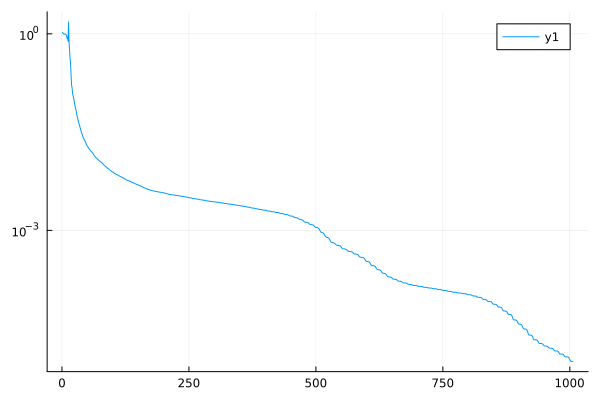

In [20]:
plot((l1s+ls) .-minimum(l1s+ls) .+1e-5,yscale=:log10)